# **Regression Model**

package import

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

Data import

In [4]:
from google.colab import files
upload = files.upload()


Saving rm_data.csv to rm_data.csv


In [5]:
rm_data = pd.read_csv('rm_data.csv')

Data test train splitting

In [6]:
rm_data_backup = rm_data.copy()

In [7]:
rm_data = rm_data.drop(['sales','date'],axis=1)
train, test = rm_data[0:-12].values, rm_data[-12:].values

In [8]:
rm_data.head()

,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


In [9]:
test_backup = test.copy()

In [10]:
train_backup = train.copy()

In [11]:
test.shape, train.shape

((12, 13), (35, 13))

### **Data scaling**

Apply Min Max Scaler

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

In [13]:
scaler

MinMaxScaler(feature_range=(-1, 1))

Reshape train data set

In [14]:
train = train.reshape(train.shape[0], train.shape[1])
scaled_train = scaler.transform(train)

Reshape test data set

In [15]:
test = test.reshape(test.shape[0], test.shape[1])
scaled_test = scaler.transform(test)

In [16]:
test.shape[0]

12

In [17]:
test_backup.shape[0]

12

Model data

Reusable scale function



In [18]:
def apply_scale(train_set, test_set):
    #Apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # Reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # Reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler


In [19]:
X_train, y_train, X_test, y_test, scaler_object = apply_scale(train, test)

In [20]:
X_train.shape, y_train.shape

((35, 12), (35,))

In [21]:
X_test.shape, y_test.shape

((12, 12), (12,))

Model Functions

In [22]:
def undo_scale(y_prediction, x_test, scaler_obj, lstm=False):  
    # Reshape y_prediction
    y_prediction = y_prediction.reshape(y_prediction.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    # Rebuild test set for inverse transform
    prediction_test = []
    for index in range(0,len(y_prediction)):
        prediction_test.append(
            np.concatenate([y_prediction[index],x_test[index]],axis=1))
        
    # Reshape prediction_test
    prediction_test = np.array(prediction_test)
    prediction_test = prediction_test.reshape(
        prediction_test.shape[0], prediction_test.shape[2])
    
    # Inverse transform
    prediction_test_inverted = scaler_obj.inverse_transform(prediction_test)
    
    return prediction_test_inverted

Load raw data 

In [23]:
from google.colab import files
upload = files.upload()

Saving train.csv to train.csv


In [24]:
raw_data = pd.read_csv('train.csv')

In [25]:
raw_data.date = raw_data.date.apply(lambda x: str(x)[:-3])
raw_data = raw_data.groupby('date')['sales'].sum().reset_index()
raw_data.date = pd.to_datetime(raw_data.date)

In [26]:
raw_data.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [27]:
raw_data_backup = raw_data.copy()

Prediction function

In [28]:
def prediction_data(unscaled_predictions, raw_data):
    # Create dataframe that shows the predicted sales
    results = []
    sales_dates = list(raw_data[-13:].date)
    sales_count = list(raw_data[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        prediction = {}
        prediction['pred_value'] = int(
            unscaled_predictions[index][0] + sales_count[index])
        prediction['date'] = sales_dates[index+1]
        results.append(prediction)
    
    return pd.DataFrame(results)

Store each models scores in score dictionary

In [29]:
scores = {}

Function to get score for each model

In [30]:
def get_model_scores(unscaled_data, raw_data, model_name):
    rmse = np.sqrt(
        mean_squared_error(raw_data.sales[-12:], 
                           unscaled_data.pred_value[-12:]))
    mae = mean_absolute_error(
        raw_data.sales[-12:], 
        unscaled_data.pred_value[-12:])
    r2 = r2_score(raw_data.sales[-12:], unscaled_data.pred_value[-12:])
    
    scores[model_name] = {
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }

    print("Model score : ", scores[model_name])

Plot model results

In [31]:
def plot_predictions(predictions, original_df, model_name):

    fig, axis = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, 
                 data=original_df, ax=axis, 
                 label='Original', color='green')
    sns.lineplot(predictions.date, predictions.pred_value, 
                 data=predictions, ax=axis, 
                 label='Predicted', color='Red')
    
    axis.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    axis.legend()
    
    sns.despine()
    
    plt.savefig(f'output/{model_name}_forecast.png')

Model executor

In [32]:
def exec_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = apply_scale(
        train_data, test_data)
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    temp_data = raw_data.copy()
    unscaled = undo_scale(predictions, X_test, scaler_object)
    unscaled_df = prediction_data(unscaled, temp_data)
    
    get_model_scores(unscaled_df, temp_data, model_name)

    plot_predictions(unscaled_df, temp_data, model_name)

## **Linear regression**

Model score :  {'rmse': 16221.040790693221, 'mae': 12433.0, 'r2': 0.9907155879704752}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


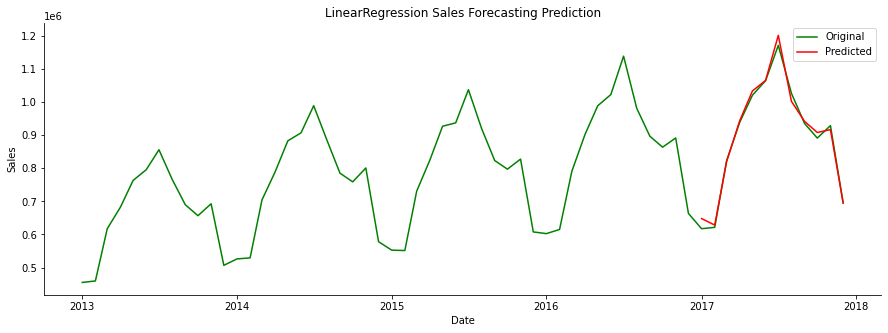

In [35]:
exec_model(train, test, LinearRegression(), 'LinearRegression')

## **Random Forest**

Model score :  {'rmse': 19612.805043304405, 'mae': 16511.0, 'r2': 0.9864269829234903}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


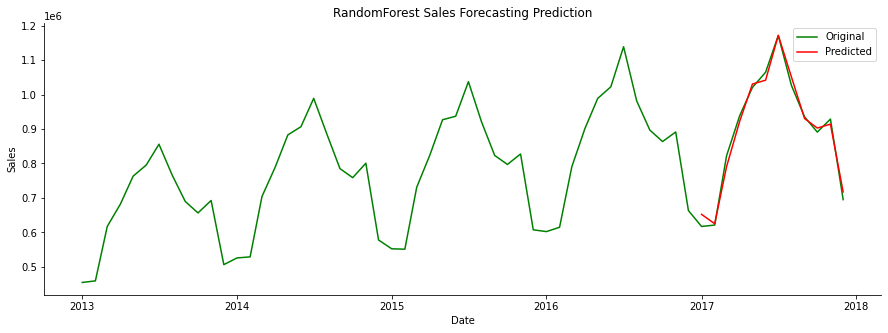

In [36]:
exec_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

## **XGBoost**

Model score :  {'rmse': 13574.792631933646, 'mae': 11649.666666666666, 'r2': 0.9934977542289017}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


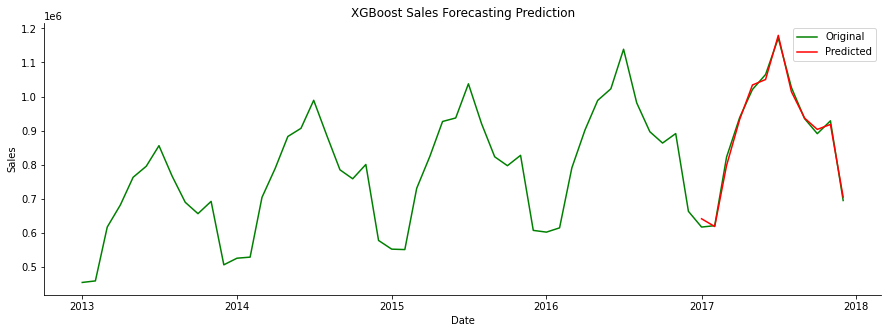

In [42]:
exec_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

## **LSTM**

In [43]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = apply_scale(
        train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    temp_data = raw_data_backup.copy()
    unscaled = undo_scale(predictions, X_test, scaler_object, lstm=True)
    unscaled_data = prediction_data(unscaled, temp_data)
    
    get_model_scores(unscaled_data, temp_data, 'LSTM')
    
    plot_predictions(unscaled_data, temp_data, 'LSTM')

Epoch 1/200
35/35 [==============================] - 2s 2ms/step - loss: 0.1536
Epoch 2/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1529
Epoch 3/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1372
Epoch 4/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1259
Epoch 5/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1165
Epoch 6/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1081
Epoch 7/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1004
Epoch 8/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0933
Epoch 9/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0866
Epoch 10/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0805
Epoch 11/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0747
Epoch 12/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0692
Epoch 13/200
35/35 [=================

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


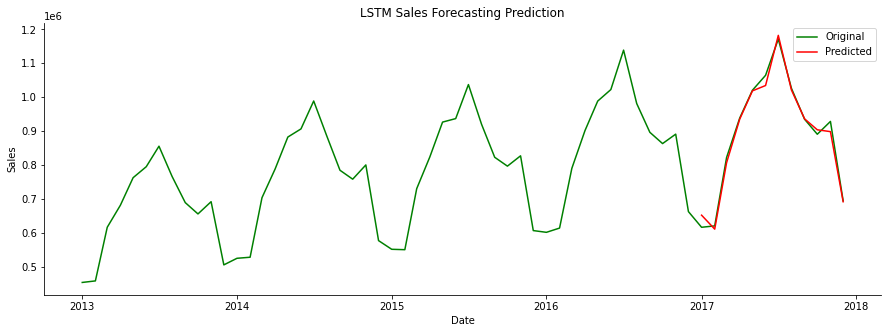

In [44]:
lstm_model(train, test)

In [45]:
pickle.dump(scores, open( "scores.p", "wb" ) )